In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

In [2]:
# Set to your CSV path
DATA_PATH = "./shopping_trends.csv"   # columns expected: date, gender, category, amount

df = pd.read_csv(DATA_PATH)   # load raw, no parse_dates
print(df.columns.tolist())    # see actual column names
df.head()


['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Preferred Payment Method', 'Frequency of Purchases']


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


Only focus on relevant columns that affects purchase amount

In [3]:
df = df[["Age", "Gender", "Season", "Category", "Purchase Amount (USD)"]].copy()
df = df.rename(columns={"Purchase Amount (USD)": "PurchaseAmount"})

<h1>EDA</h1>

Check correlation to ensure that the columns affects purchase amount

Correlation (Age vs PurchaseAmount): -0.010


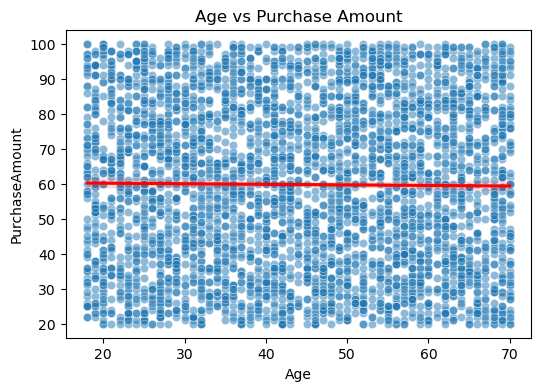

In [4]:
# Age vs purchase amount
corr_age = df["Age"].corr(df["PurchaseAmount"])
print(f"Correlation (Age vs PurchaseAmount): {corr_age:.3f}")

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="Age", y="PurchaseAmount", alpha=0.5)
sns.regplot(data=df, x="Age", y="PurchaseAmount", scatter=False, color="red")
plt.title("Age vs Purchase Amount")
plt.show()

Correlation is very close to 0 , no linear relationship between age and purchase amount.
Suggest that not an important feature for prediction of purchase amount

C:\Users\joelyn chua\AppData\Local\Temp\ipykernel_39836\2665984710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Season", y="PurchaseAmount", palette="Set3")


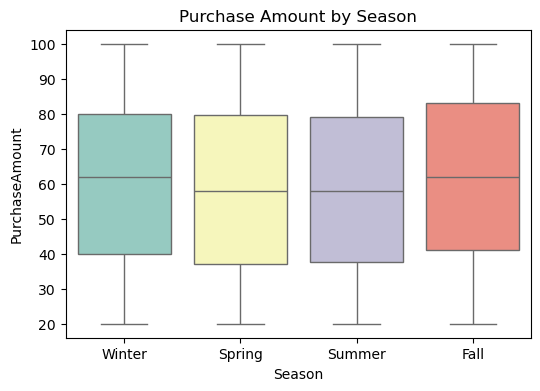

ANOVA test for Season effect on PurchaseAmount: F_onewayResult(statistic=3.7461183460998164, pvalue=0.010576155629494032)


In [5]:
# Season vs purchase amount
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Season", y="PurchaseAmount", palette="Set3")
plt.title("Purchase Amount by Season")
plt.show()

anova_season = stats.f_oneway(
    *[df[df["Season"] == s]["PurchaseAmount"] for s in df["Season"].unique()]
)
print("ANOVA test for Season effect on PurchaseAmount:", anova_season)

p < 0.05 → statistically significant difference
This means purchase amount varies depending on the season.
Important feature for predicting purchase amount

C:\Users\joelyn chua\AppData\Local\Temp\ipykernel_39836\3072538791.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Gender", y="PurchaseAmount", palette="Set2")


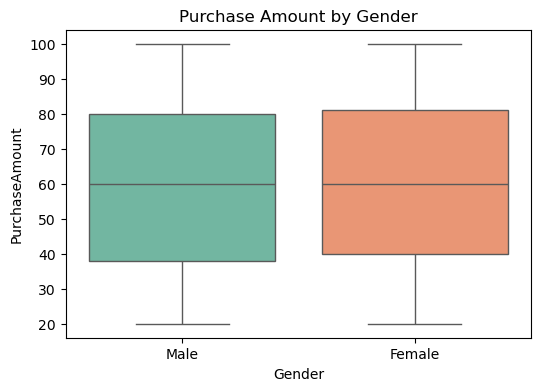

ANOVA test for Gender effect on PurchaseAmount: F_onewayResult(statistic=0.7689802793962787, pvalue=0.38058673555215927)


In [6]:
# Gender vs purchase amount
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Gender", y="PurchaseAmount", palette="Set2")
plt.title("Purchase Amount by Gender")
plt.show()

anova_gender = stats.f_oneway(
    *[df[df["Gender"] == g]["PurchaseAmount"] for g in df["Gender"].unique()]
)
print("ANOVA test for Gender effect on PurchaseAmount:", anova_gender)

p > 0.05 → no statistically significant difference.
Gender is not important for predicting purchase amount.

C:\Users\joelyn chua\AppData\Local\Temp\ipykernel_39836\409596947.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Category", y="PurchaseAmount", palette="Set1")


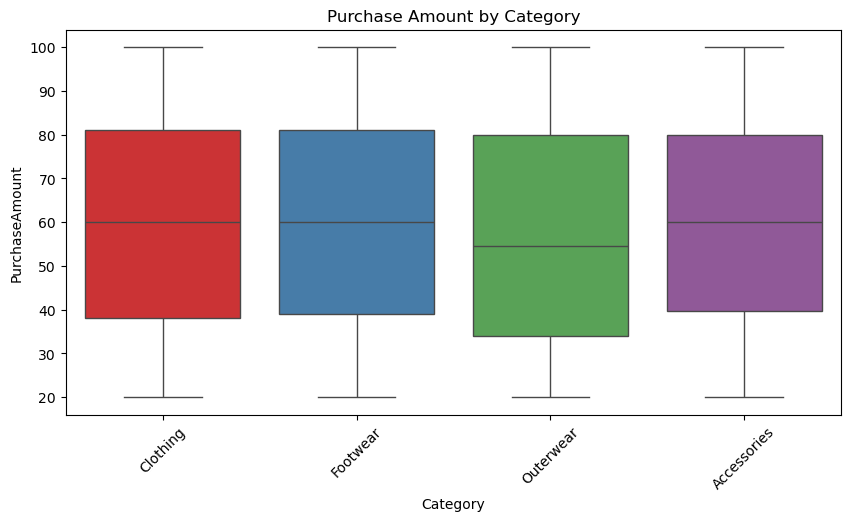

ANOVA test for Category effect on PurchaseAmount: F_onewayResult(statistic=1.4536190218138958, pvalue=0.225219398858934)


In [7]:
# Category vs purchase amount
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Category", y="PurchaseAmount", palette="Set1")
plt.xticks(rotation=45)
plt.title("Purchase Amount by Category")
plt.show()

anova_category = stats.f_oneway(
    *[df[df["Category"] == c]["PurchaseAmount"] for c in df["Category"].unique()]
)
print("ANOVA test for Category effect on PurchaseAmount:", anova_category)

p > 0.05 → no statistically significant difference across categories.
Category is not strongly predictive of purchase amount.

In [8]:
# Preparation
# Focus only on Season and Purchase Amount
df = df[["Season", "PurchaseAmount"]].dropna()

# Features and target
X = df[["Season"]]
y = df["PurchaseAmount"]

# One-hot encode Season
encoder = OneHotEncoder(drop="first", sparse=False)  # drop first to avoid multicollinearity
X_encoded = encoder.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

c:\Users\joelyn chua\anaconda3\envs\ai\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
print(df.columns.tolist())

['Season', 'PurchaseAmount']


In [10]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

print("📈 Linear Regression Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("R²:", r2_score(y_test, y_pred_lin))
print("Coefficients:", dict(zip(encoder.get_feature_names_out(), lin_reg.coef_)))

📈 Linear Regression Performance
MAE: 20.737684975646324
R²: -0.007529368911694423
Coefficients: {'Season_Spring': -2.4452380952380905, 'Season_Summer': -3.8209666322669293, 'Season_Winter': -1.184808162187149}


In [11]:
# random forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🌲 Random Forest Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))


🌲 Random Forest Performance
MAE: 20.74114846081837
R²: -0.007733360643088272


In [13]:
# After you build X as a pandas DataFrame (e.g., via get_dummies)
# X = pd.get_dummies(df[["Age","Gender","Category","Season"]], drop_first=True)
feature_names = X.columns.tolist()   # <-- capture BEFORE the split

# ... then do your train/test split and training ...

# === Save Model & Feature Names ===
import joblib

joblib.dump(lin_reg, "linear_regression_model.pkl")
print("✅ Model saved as linear_regression_model.pkl")

joblib.dump(feature_names, "model_features.pkl")   # <-- use the saved list, not X_train.columns
print("✅ Features saved as model_features.pkl")


✅ Model saved as linear_regression_model.pkl
✅ Features saved as model_features.pkl
